# Logistic Regression

In [1]:
%matplotlib inline
#%pylab
import numpy as np
import matplotlib.animation as animation 
import matplotlib.pyplot as plt
from matplotlib import style 
import theano
import theano.tensor as T
import time

/Users/vitormeriat/anaconda/lib/python3.6/site-packages/theano/configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [4]:
data  = np.loadtxt('../data/ex2data1.txt', delimiter=',', dtype='float32')
X = data[:, [0, 1]]
Y= data[:, 2]
m = len(X)

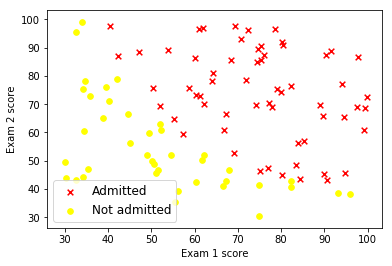

In [5]:
fig = plt.figure()
pos = plt.scatter(X[Y == 1, 0], X[Y == 1, 1], s=32, c='red', marker='x')
neg = plt.scatter(X[Y == 0, 0], X[Y == 0, 1], s=32, c='yellow', marker='o')
plt.xlabel('Exam 1 score')
plt.ylabel('Exam 2 score')
# Isso adiciona atraso à dispersão
plt.legend((pos, neg), ('Admitted', 'Not admitted'), scatterpoints=1, loc='lower left', ncol=1, fontsize=12) 

In [6]:
# Adicione uma coluna 1 no X
XTemp = np.ones([m,3], dtype='float32')
XTemp[:, [1, 2]] = X
X = XTemp

## sigmod function

$$ g(z) = \frac {1} { 1 + e ^ {-z} } $$

In [7]:
def sigmoid(z):
    return 1 / (1 + T.exp(-z))

## Modelo

hypothesis

$$ h _ { \theta } (x) = g ( \theta ^ Tx ) $$

loss function

$$ J ( \theta ) = \frac {1} {m} \sum{ i=1 } ^ {m} \left[ - y^ { (i) } \log ( h{ \theta } ( x ^ { (i) } ) ) - (1 - y^{ (i) } ) \log ( 1 - h_{ \theta } ( x ^ { (i) } ) ) \right] $$ 

Derivação da função de perda de regressão logística

In [8]:
# Coloque os dados de treinamento em gpu (100, 3) 
x = theano.shared(X, name='x')  
# (100, )
y = theano.shared(Y, name='y')  
theta = theano.shared(np.zeros([3, 1], dtype='float32'), name='theta')
# Taxa de aprendizagem
alpha = T.scalar('alpha') 
# (100, 1)
pre_prob = sigmoid(x.dot(theta)) 
# y precisa ser vetor, precisa de dimshuffle
loss = T.mean(-y.dimshuffle(0, 'x') * T.log(pre_prob) - (1- y.dimshuffle(0, 'x')) * T.log(1 - pre_prob)) 
calcLoss = theano.function([], loss)
# Calcular a precisão da classificação
precision = theano.function([], T.eq(T.ge(pre_prob, 0.5), y.dimshuffle(0, 'x')).sum() / T.cast(x.shape[0], 'float32')) 

gradient w.s.t theta

$$ \frac{ \partial { J ( \theta ) } } { \partial { \thetaj } } = \frac {1} {m} \sum{ i = 1} ^ {m} \left ( h_{ \theta } (x^{ (i) } ) - y^{ (i) } \right ) x_j^{ (i) } $$

update theta with gradient descent

$$ \theta = \theta - \alpha \nabla \theta $$



In [10]:
# Gradiente
grad_all = T.mean((pre_prob - y.dimshuffle(0, 'x')).repeat(3, 1) * x, axis=0)  
# Gradiente descendente
gradient_step_all = theano.function([alpha],updates={theta : theta - alpha * grad_all.dimshuffle(0, 'x')})

TypeError: ('An update must have the same type as the original shared variable (shared_var=theta, shared_var.type=TensorType(float32, matrix), update_val=Elemwise{sub,no_inplace}.0, update_val.type=TensorType(float64, matrix)).', 'If the difference is related to the broadcast pattern, you can call the tensor.unbroadcast(var, axis_to_unbroadcast[, ...]) function to remove broadcastable dimensions.')

In [11]:
# Gradiente automaticamente
grad_auto = T.grad(loss, theta) 
gradient_step_auto = theano.function([alpha],updates={theta : theta - alpha * grad_auto})

TypeError: ('An update must have the same type as the original shared variable (shared_var=theta, shared_var.type=TensorType(float32, matrix), update_val=Elemwise{sub,no_inplace}.0, update_val.type=TensorType(float64, matrix)).', 'If the difference is related to the broadcast pattern, you can call the tensor.unbroadcast(var, axis_to_unbroadcast[, ...]) function to remove broadcastable dimensions.')

In [13]:
print(calcLoss()) 
print(grad_all.eval({})) 
print(grad_auto.eval({})) 

0.6931471824645996
[ -0.1        -12.00921631 -11.26284218]
[[ -0.10000001]
 [-12.00921535]
 [-11.26284122]]


## Treinamento de otimização de descida de gradiente

In [15]:
# cpu 39.1s, gpu (meio lento...)
startTime = time.time() 
# Treinamento, ajuste dinâmico de gradientes
theta.set_value(np.zeros([3, 1], dtype='float32'))
max_iters = 100000
alpha = 0.1
best_loss = np.Inf
best_theta = theta.get_value()
J_history = np.zeros((max_iters, 1))
for i in range(max_iters):
    theta.set_value(best_theta)
    gradient_step_auto(alpha)
    tempLoss = calcLoss()
    J_history[i] = tempLoss
    if tempLoss < best_loss:
        best_loss = tempLoss
        best_theta = theta.get_value()
    else:
        alpha = alpha * 0.99
endTime = time.time()
print(theta.get_value()) 
print('training cost %.1fs' % (endTime - startTime)) 

NameError: name 'gradient_step_auto' is not defined

## Use o módulo de otimização do scipy para treinamento de otimização e demonstre dinamicamente o processo iterativo

In [16]:
# Calcular o custo para o teta especificado Ao usar a função de otimização, o parâmetro a ser otimizado 
# é um vetor unidimensional, portanto, para converter em um vetor de coluna bidimensional, e ao usar fmin 
# também precisa ser convertido para o tipo float32
def computeCost(theta_value):
    theta.set_value(theta_value.reshape(3,1).astype('float32'))
    return calcLoss()

# Calcular o gradiente ao especificar teta
calcGrad= theano.function([], grad_auto)
def train_fn_grad(theta_value):
    theta.set_value(theta_value.reshape(3,1).astype('float32'))
    return np.array(calcGrad().reshape(3)) # O gradiente também deve ser convertido em vetor unidimensional

In [17]:
%matplotlib auto
from scipy import optimize
# Armazene o resultado após cada iteração
thetaV = [] 
def optimizeTheta():
    # Uma forma vetorial unidimensional de x0 passou para theta
    # Use fmin para encontrar a solução ideal, usando Nelder-Mead (método simplista)
    result = optimize.fmin(computeCost, x0=np.zeros(3, dtype=theano.config.floatX), maxiter=1000, 
                           full_output=True, callback=lambda t : thetaV.append(t.reshape(3, 1)))     
    return result[0], result[1]
thetaValue, mincost = optimizeTheta()
print(thetaValue) 

# Processo iterativo de demonstração animada
# Dinamicamente traçar limites de decisão
def plotDecisionBoundaryAnimation(i): 
    # Desenhar pontos de dados primeiro
    fig.clear()
    pos = plt.scatter(X[Y == 1, 1], X[Y == 1, 2], s=32, c='red', marker='x')
    neg = plt.scatter(X[Y == 0, 1], X[Y == 0, 2], s=32, c='yellow', marker='o')
    plt.xlabel('Exam 1 score')
    plt.ylabel('Exam 2 score')
    # Isso adiciona atraso à dispersão
    plt.legend((pos, neg), ('Admitted', 'Not admitted'), scatterpoints=1, loc='lower left', ncol=1, fontsize=12) 
    # Traçar limites de decisão
    plot_x = [X[:, 1].min() - 2, X[:, 1].max() + 2]
    plot_y = -(thetaV[i][1] * plot_x + thetaV[i][0]) / thetaV[i][2]
    plt.plot(plot_x, plot_y)

# Processo de otimização iterativa de demonstração dinâmica
fig = plt.figure() 
# call animate desenho a cada 10ms
ani = animation.FuncAnimation(fig, plotDecisionBoundaryAnimation, frames=len(thetaV), interval = 1) 
plt.show() 

Using matplotlib backend: MacOSX
Optimization terminated successfully.
         Current function value: 0.203498
         Iterations: 147
         Function evaluations: 286
[-25.15893008   0.20621288   0.2014551 ]


In [18]:
# Usando a otimização de função mínima, somente o Nelder-Mead pode encontrar a solução ideal.
result = optimize.minimize(computeCost, np.zeros(3, dtype=theano.config.floatX),  method='Nelder-Mead', options={"maxiter":500, "disp":True} )
thetaValue, mincost = np.array([result.x]), result.fun
print(thetaValue)

Optimization terminated successfully.
         Current function value: 0.203498
         Iterations: 147
         Function evaluations: 286
[[-25.15893008   0.20621288   0.2014551 ]]


In [19]:
# Use os parâmetros calculados para classificar e encontrar a precisão da classificação
theta.set_value(thetaValue.reshape(3, 1).astype('float32')) # Definir o valor de theta
precision()

array(0.89)

In [20]:
# Usando a otimização do gradiente conjugado, relatou nan
thetaValue = optimize.fmin_cg(
    f=computeCost,
    x0=np.random.rand(3,1),
    fprime=train_fn_grad,
    disp=1,
    maxiter=1000
)

         Current function value: 0.703593
         Iterations: 1
         Function evaluations: 120
         Gradient evaluations: 108


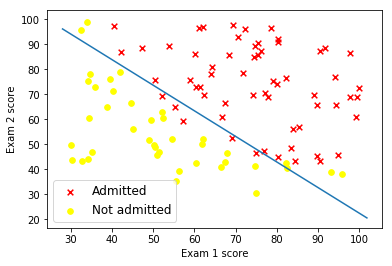

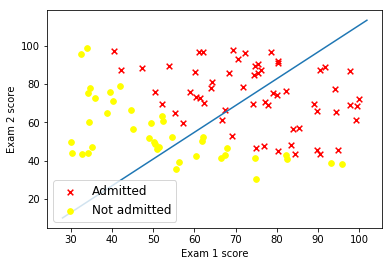

In [21]:
# Comparar resultados de matlab
%matplotlib inline
def plotDecisionBoundary(theta, X, Y): # Traçar limites de decisão
    # Desenhar pontos de dados primeiro
    fig = plt.figure()
    pos = plt.scatter(X[Y == 1, 1], X[Y == 1, 2], s=32, c='red', marker='x')
    neg = plt.scatter(X[Y == 0, 1], X[Y == 0, 2], s=32, c='yellow', marker='o')
    plt.xlabel('Exam 1 score')
    plt.ylabel('Exam 2 score')
    # Isso adiciona atraso à dispersão
    plt.legend((pos, neg), ('Admitted', 'Not admitted'), scatterpoints=1, loc='lower left', ncol=1, fontsize=12) 
    # Traçar limites de decisão
    plot_x = [X[:, 1].min() - 2, X[:, 1].max() + 2]
    plot_y = -(theta[1] * plot_x + theta[0]) / theta[2]
    plt.plot(plot_x, plot_y)
    
# Este é o resultado do matlab usando otimização fminunc
plotDecisionBoundary(np.array([[-24.932998460539014],[0.204407718945030],[0.199618080892081]]), X, Y) 
plotDecisionBoundary(theta.get_value(), X, Y)

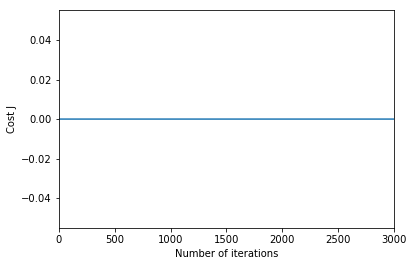

In [22]:
# Plot the convergence graph
fig = plt.figure() 
plt.plot(np.arange(max_iters) + 1, J_history)
plt.xlim(0, 3000)
plt.xlabel('Number of iterations')
plt.ylabel('Cost J')

In [24]:
# Use o sklearn para treinar modelos de regressão logística

from sklearn.linear_model import LogisticRegression  
lr = LogisticRegression(solver='newton-cg') # ou use liblinear...
lr.fit(X,Y) # Treinamento
print((lr.predict(X) == Y).sum()/100.0) # Precisão
print(lr.coef_) # Coeficiente

0.89
[[ -1.78893803e-15   2.05353688e-01   2.00582767e-01]]


## Derivação da função de perda de regressão logística

Como o domínio da função sigmóide é $ ( -\infty , + \infty ) $, o alcance é $ ( 0 , 1 ) $，ela pode ser vista como uma representação de probabilidade, considerando a função sigmóide como a função de densidade de probabilidade dos dados da amostra, e para cada ponto de amostragem, sua densidade de probabilidade pode ser calculada pela função sigmóide.

Considere $x$ 具vector com p variáveis independentes $ x^T = ( x_1 , x_2 , \cdots , xp ) $，probabilidade condicional $ P ( Y=1 \mid x ; \theta ) = p $ por um dado $x$，$Y = 1$ A probabilidade. O modelo de regressão logística pode ser expresso como: $$ \begin{align} & h{ \theta } (x) = \frac {1} { 1 + e^{ - \theta^Tx } } \notag \ & P ( Y = 1 \mid x ; \theta ) = h{ \theta } (x) \notag \ & P ( Y = 0 \mid x; \theta) = 1 - h{ \theta } (x) \notag \end{align} $$
Suponha que existem n amostras de observação, e os valores de observação são $ y_1 , y_2 , \cdots , y_n $，configurar $ p_i = P ( y^{ (i) } = 1 \mid x^{ (i) } : \theta ) $ obtido por uma determinada condição $ y_i = 1 $ a probabilidade é obtida sob as mesmas condições $ y_i = 0 $ a probabilidade condicional é $ P( y^{ (i) } = 0 \mid x^{ (i) } : \theta ) = 1 - p_i $ . Assim, a probabilidade de obter uma observação é: $$ \begin{align} P(y_i) &= p_i^{ y^{ (i) } } ( 1 - pi )^{ 1 - y^{ (i) } } \notag \ &= \left ( h{\theta} (x^{ (i) }) \right )^{ y^{ (i) } } \left( 1 - h{\theta} (x^{ (i) }) \right )^{1- y^{ (i) } } \notag \end{align} $$
Como as observações são independentes, sua distribuição conjunta pode ser expressa como o produto das distribuições marginais: $$ \begin{align} L ( \theta ) &= p( \vec y \mid X ; \theta ) \notag \ &= \prod{i=1}^n p \left ( y^{(i)} \mid x^{(i)} ; \theta \right ) \notag \ &= \prod{i=1}^n \left ( h{\theta} (x^{(i)}) \right )^{ y^{(i)} } \left( 1 - h{\theta} (x^{(i)}) \right )^{1- y^{(i)} } \notag \end{align} $$
A fórmula acima é chamada n funções de verossimilhança observadas. Nosso objetivo é ser capaz de encontrar estimativas de parâmetros que maximizem o valor dessa função de verossimilhança. Então, a chave para a estimativa da máxima verossimilhança é encontrar os parâmetros $\theta$，Deixe a fórmula obter o valor máximo.

Encontre o logaritmo da função acima:
$$ \begin{align} \ell ( \theta ) &= \log L( \theta ) \notag \ &= \sum{ i = 1 }^n y^{(i)} \log h( x^{(i)} ) + ( 1 - y^{(i)}) \log ( 1 - h ( x^{(i)} ) ) \notag \end{align} $$
Depois de tirar o negativo, é precisamente para minimizar a entropia cruzada!